In [1]:
import os
import cv2
import numpy as np
from time import time
import tensorflow as tf
import keras
from tensorflow.keras import utils
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, MaxPool2D
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import pylab as py
import random
import pylab as pl
from PIL import Image, ImageFilter


In [2]:
def visualize(train_dir):
    classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 
           'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 
           'W', 'X', 'Y', 'Z', 'space', 'nothing', 'del']
    plt.figure(figsize=(15, 15))
    for i in range (0,29):
        plt.subplot(8,8,i+1)
        plt.xticks([])
        plt.yticks([])
        path = train_dir + "/{0}/{0}27.jpg".format(classes[i])
        img = plt.imread(path)
        grayImage = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        (thresh, blackAndWhiteImage) = cv2.threshold(grayImage, 127, 1, cv2.THRESH_BINARY)
        #blackAndWhiteImage = blackAndWhiteImage/255
        if(i==0):
            print(blackAndWhiteImage)
            print(img.shape)
        #img_gray = np.array(Image.open(path).convert('L'))
        #maxval = 1
        #im_bin = (img_gray > 95) * maxval
        #print(im_bin.shape)
        plt.imshow(blackAndWhiteImage)
        plt.xlabel(classes[i])

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 1 1 0]
 ...
 [0 0 1 ... 1 1 0]
 [0 0 1 ... 1 1 0]
 [0 0 0 ... 0 0 0]]
(200, 200, 3)


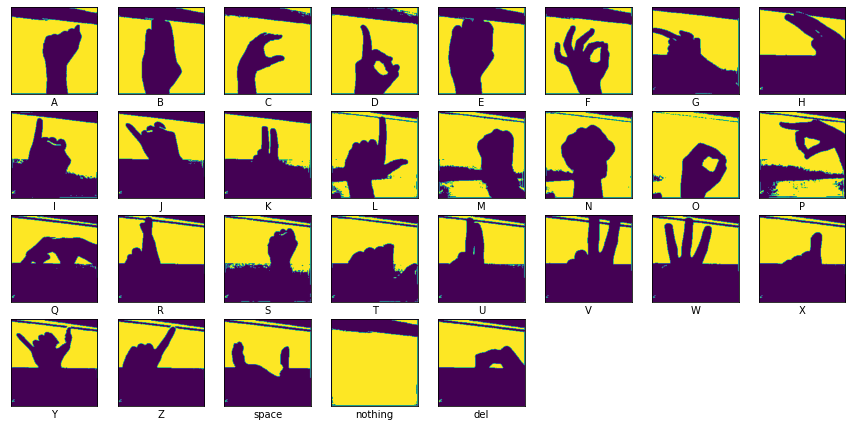

In [3]:
train_dir = './asl_alphabet_train/asl_alphabet_train'
visualize(train_dir)


In [4]:
def split_data(train_dir):
    images = []
    labels = []
    size = 64,64
    index = -1
    for folder in os.listdir(train_dir):
        index +=1
        for image in os.listdir(train_dir + "/" + folder):
            if image[0] != '.':
                temp_img = plt.imread(train_dir + '/' + folder + '/' + image)
                grayImage = cv2.cvtColor(temp_img, cv2.COLOR_BGR2GRAY)
                (thresh, temp_img) = cv2.threshold(grayImage, 127, 1, cv2.THRESH_BINARY)
                if type(temp_img) is np.ndarray:
                    temp_img = cv2.resize(temp_img, size)
                    images.append(np.reshape(temp_img,(4096)))
                    labels.append(index)
    images = np.array(images)
    #images = images.astype('float32')/255.0
    labels = utils.to_categorical(labels)
    x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size = 0.1)
    np.save("x_train.npy",x_train)
    np.save("x_test.npy",x_test)
    np.save("y_train.npy",y_train)
    np.save("y_test.npy",y_test)
    return x_train, x_test, y_train, y_test

In [10]:
#from to_import import split_data
x_train, x_test, y_train, y_test = split_data(train_dir)


In [11]:
im_bin = x_train[15]
print(x_train.shape)
#plt.imshow(im_bin)

(78300, 4096)


In [12]:
print(y_train.shape)
Y_train = []
Y_test = []
for i in range(y_train.shape[0]):
    Y_train.append(np.where(y_train[i]==1)[0][0])
for i in range(y_test.shape[0]):
    Y_test.append(np.where(y_test[i]==1)[0][0])
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)

print(Y_train.shape)


(78300, 30)
(78300,)


In [13]:
import gplearn
import pandas as pd
from gplearn.genetic import SymbolicRegressor,SymbolicClassifier
print(y_train.shape)

(78300, 30)


In [14]:
est_gp = SymbolicRegressor(population_size=100,
                           generations=200, tournament_size=30 ,stopping_criteria=0.001,
                           const_range=(0, 1.0), init_depth = (1,5),
                           metric = 'mse',
                           function_set=('add', 'sub', 'mul', 'sin', 'cos', 'tan'),
                           p_crossover=0.9, p_subtree_mutation=0.1,
                           p_hoist_mutation=0, p_point_mutation=0, verbose = 1,
                           parsimony_coefficient=0.01, random_state=0)
est_gp.fit(x_train,Y_train)
est_gp.score(x_test, Y_test)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0     6.14          1602.96       25          189.419              N/A      2.76m
   1    12.75          755.503       25          163.246              N/A      5.89m
   2    26.40          8705.72       40          137.512              N/A     11.53m
   3    35.22          3767.06       44          117.109              N/A     14.75m
   4    41.73          993.249       49          107.665              N/A     17.33m
   5    46.59          2321.78       50           102.96              N/A     19.28m
   6    49.57          748.607       51          100.266              N/A     21.64m
   7    49.77          2360.53       49          98.8361              N/A     21.58m
   8    50.86          869.187       59          91.4343              N/A  

0.0860329682899672

In [34]:
predicted = est_gp.predict(x_train)
print(predicted)
correct = 0
for i in range(Y_train.shape[0]):
    if int(predicted[i]) %29 == Y_train[i]:
        correct+=1

print("Accuracy: ", correct * 100 / Y_train.shape[0], "%" )


[17.6  15.47 14.   ... 16.75 11.05 17.81]
Accuracy:  2.4061302681992336 %


In [26]:
def fitness(y, y_pred, w):
    np.average(y==y_pred)

gplearn..make_fitness(function = fitness)

AttributeError: 'SymbolicRegressor' object has no attribute 'make_fitness'